In [53]:
import pandas as pd
#url = 'https://raw.githubusercontent.com/stesstesste/SICSS_2024/main/test_day/example_data_probabilities_new.csv'
url = 'https://raw.githubusercontent.com/stesstesste/SICSS_2024/main/data_probabilities/2023_data_probabilities.csv'
df = pd.read_csv(url)


In [54]:
import ast

df['probabilities'] = df['probabilities'].apply(ast.literal_eval)

# Creating the 'topic_primary' column
df['topic_primary'] = df['probabilities'].apply(lambda x: max(x, key=x.get))
df['topic_primary']

0                      305 - Political Authority
1                      305 - Political Authority
2                      305 - Political Authority
3                      305 - Political Authority
4                  504 - Welfare State Expansion
                          ...                   
2945                   305 - Political Authority
2946                             202 - Democracy
2947           204 - Constitutionalism: Negative
2948           203 - Constitutionalism: Positive
2949    501 - Environmental Protection: Positive
Name: topic_primary, Length: 2950, dtype: object

In [55]:
import re
df['topic_primary'] = df['topic_primary'].apply(lambda x: re.sub(r'^\d+\s*-\s*', '', x))
df['topic_primary']

0                      Political Authority
1                      Political Authority
2                      Political Authority
3                      Political Authority
4                  Welfare State Expansion
                       ...                
2945                   Political Authority
2946                             Democracy
2947           Constitutionalism: Negative
2948           Constitutionalism: Positive
2949    Environmental Protection: Positive
Name: topic_primary, Length: 2950, dtype: object

In [56]:
df['topic_primary_alt'] = df['topic_primary'].apply(lambda x: re.sub(r': (Negative|Positive)', '', x))
df['topic_primary_alt']

0            Political Authority
1            Political Authority
2            Political Authority
3            Political Authority
4        Welfare State Expansion
                  ...           
2945         Political Authority
2946                   Democracy
2947           Constitutionalism
2948           Constitutionalism
2949    Environmental Protection
Name: topic_primary_alt, Length: 2950, dtype: object

In [137]:
# Limit it to

unique_observations = df['topic_primary_alt'].unique()

#print(unique_observations)
df = df[(df['topic_primary_alt'] != 'Political Authority')&(df['Party_orientation'] != '-')& (df["Speaker_party"]!="MNOÖ")]
df['Speaker_party'] = df['Speaker_party'].str.replace(r'-frakció', '', regex=True)

df.loc[df['Speaker_party'].str.contains(r'KDNP', case=False, na=False), 'Party_orientation'] = 'Right to far-right'
df.loc[df['Speaker_party'].str.contains(r'KDNP', case=False, na=False), 'Party_orientation'] = 'Right to far-right'
df.loc[df['Speaker_party'].str.contains(r'LMP', case=False, na=False), 'Party_orientation'] = 'Green / left'
df.loc[df['Speaker_party'].str.contains(r'Párbeszéd', case=False, na=False), 'Party_orientation'] = 'Green / left'

#new_df['Party_family'] = NaN



frequency_table = df['topic_primary_alt'].value_counts().reset_index()
frequency_table.columns = ['topic_primary_alt', 'frequency']
frequency_table = frequency_table.sort_values(by='frequency', ascending=False)

# Display the frequency table
print(frequency_table)

# Get the top 10 categories
top_10_categories = frequency_table.head(10)['topic_primary_alt'].tolist()

# Drop observations from df where 'topic_primary_alt' is not in the top 10 categories
df_top10 = df[df['topic_primary_alt'].isin(top_10_categories)]


                             topic_primary_alt  frequency
0                     European Community/Union        121
1                      Welfare State Expansion        118
2                          Education Expansion        117
3                                    Democracy        115
4                     Environmental Protection        115
5                         National Way of Life        111
6                Technology and Infrastructure         89
7                                     Military         73
8                                Law and Order         72
9                         Political Corruption         72
10                               Labour Groups         71
11                                       Peace         66
12                           Market Regulation         65
13                    Freedom and Human Rights         58
14                     Agriculture and Farmers         57
15                        Traditional Morality         51
16  Government

In [138]:
unique_party_orientation_table = df.groupby('Speaker_party')['Party_orientation'].unique().reset_index()

# Display the table
print(unique_party_orientation_table)

  Speaker_party     Party_orientation
0            DK         [Centre-left]
1        Fidesz  [Right to far-right]
2        JOBBIK        [Centre-right]
3          KDNP  [Right to far-right]
4          KNDP  [Right to far-right]
5           LMP        [Green / left]
6          MSZP         [Centre-left]
7     Mi Hazánk           [Far-right]
8      Momentum              [Centre]
9     Párbeszéd        [Green / left]


In [139]:
!pip install textstat


In [140]:
# Text complexity
import textstat

# Assuming new_data is your DataFrame with the text variable
# Example new_data structure:
# new_data = pd.DataFrame({
#     'Text_ID': [1, 2],
#     'text': ["This is a sample text.", "This is another example."]
# })

# Define a function to calculate complexity scores
def calculate_complexity_scores(text):
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'gunning_fog': textstat.gunning_fog(text),
        'ari': textstat.automated_readability_index(text),
        'smog_index': textstat.smog_index(text)
    }

# Apply the function to each text
complexity_scores = df_top10['text'].apply(calculate_complexity_scores)
complexity_df = pd.DataFrame(complexity_scores.tolist())

# Combine the original DataFrame with the complexity scores
new_df = pd.concat([df_top10, complexity_df], axis=1)



In [141]:

# Convert complexity score columns to numeric
for column in ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'ari', 'smog_index']:
    new_df[column] = pd.to_numeric(new_df[column], errors='coerce')


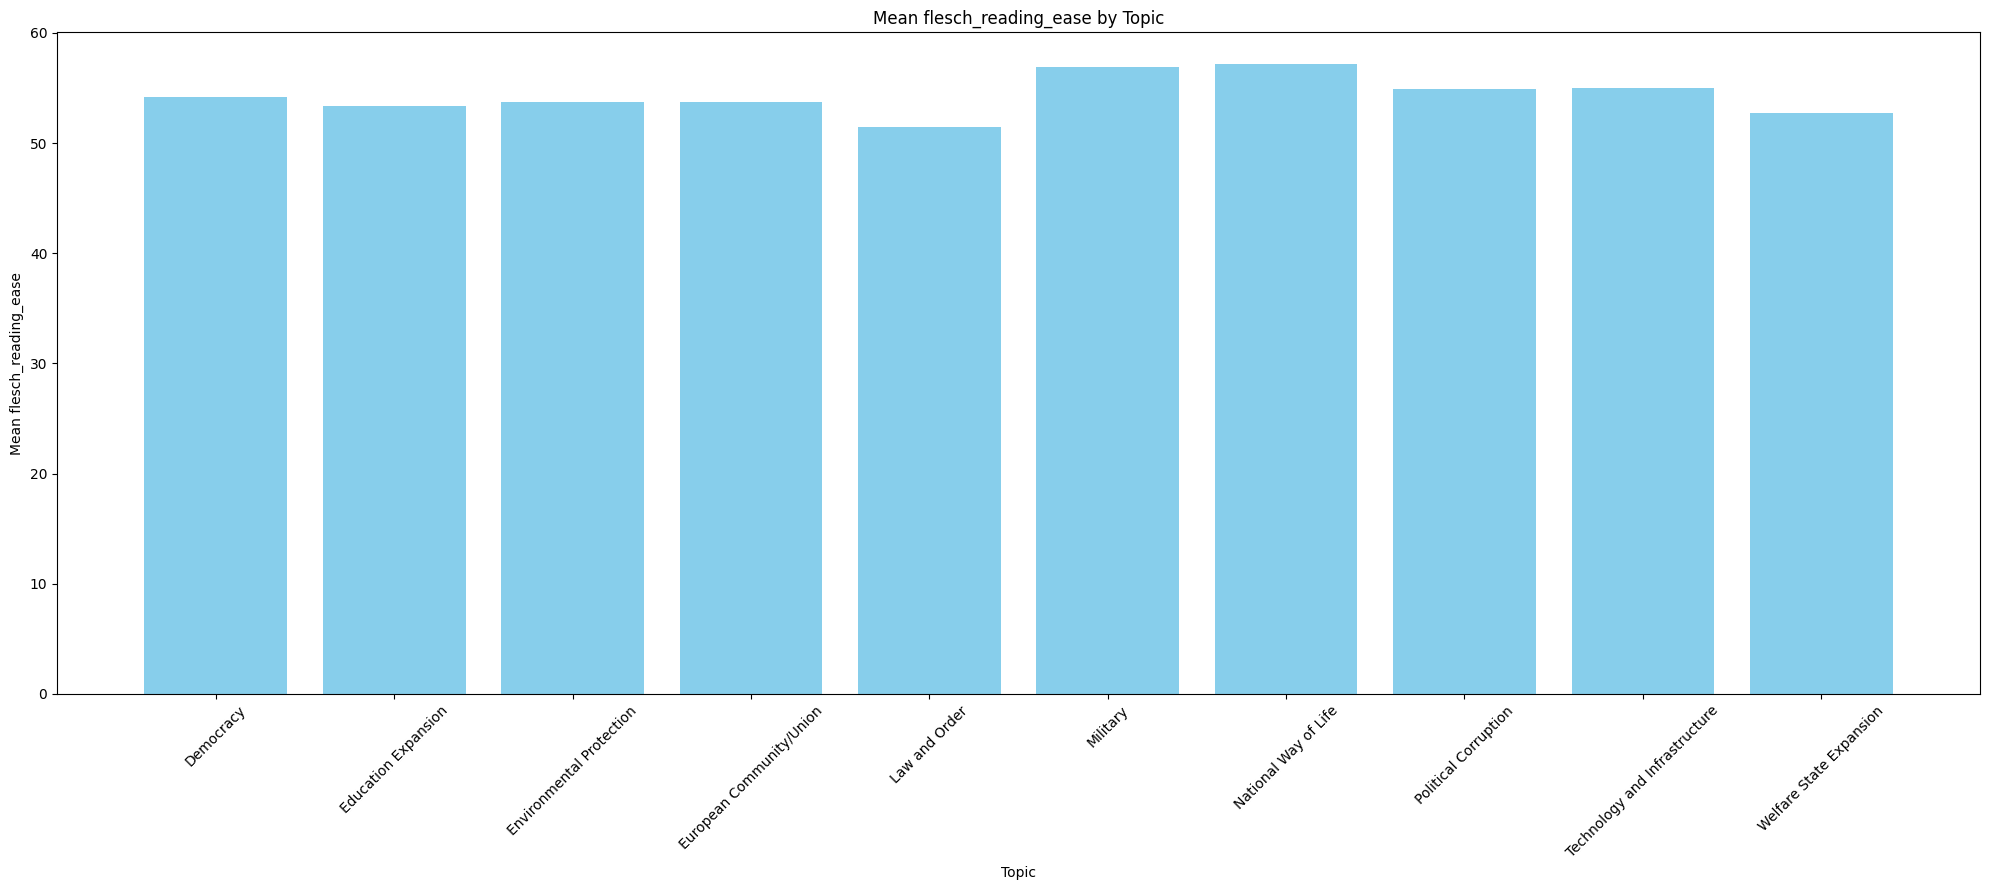

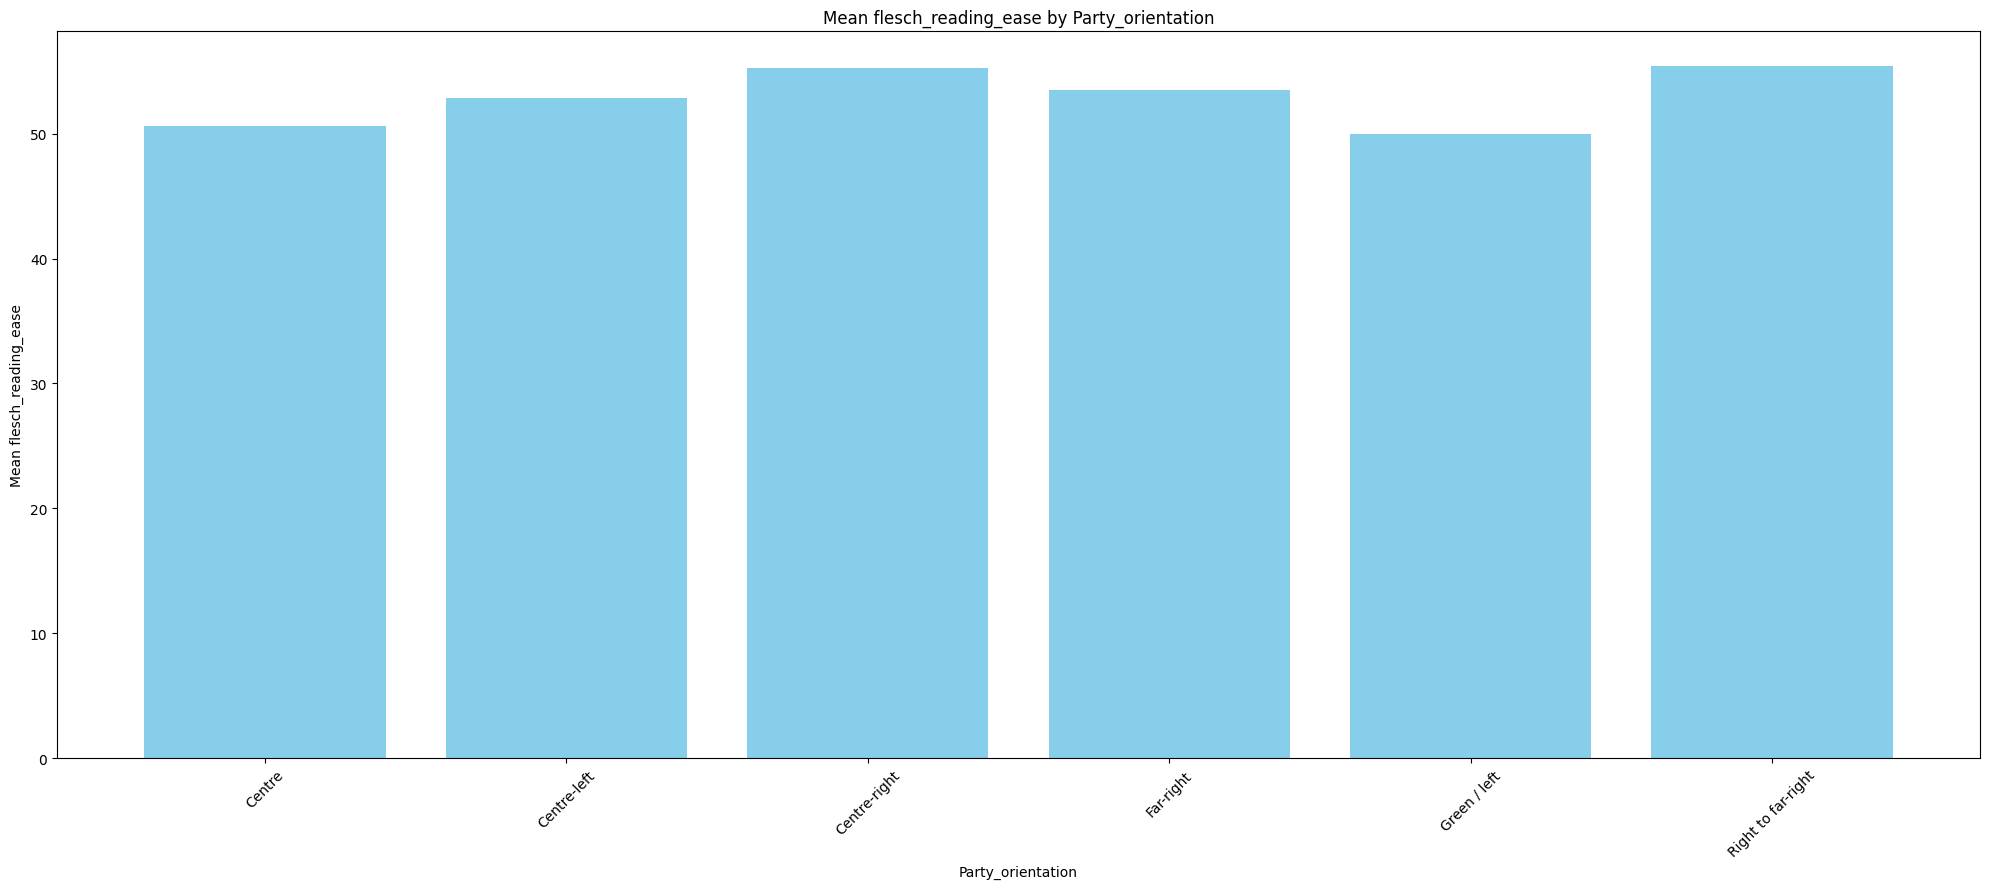

In [142]:
import matplotlib.pyplot as plt

# Convert 'topic_primary_alt' to categorical if necessary
new_df['topic_primary_alt'] = new_df['topic_primary_alt'].astype('category')

# List of numeric columns to plot
#numeric_columns = ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'ari', 'smog_index']
numeric_columns = ['flesch_reading_ease']

# Group by 'topic_primary_alt' and calculate the mean for each numeric column
mean_values = new_df.groupby('topic_primary_alt')[numeric_columns].mean().reset_index()

# Plot bar charts for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(20, 9))  # Increased width to 15
    plt.bar(mean_values['topic_primary_alt'], mean_values[column], color='skyblue')
    plt.xlabel('Topic')
    plt.ylabel(f'Mean {column}')
    plt.title(f'Mean {column} by Topic')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Group by 'topic_primary_alt' and calculate the mean for each numeric column
mean_values = new_df.groupby('Party_orientation')[numeric_columns].mean().reset_index()

# Plot bar charts for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(20, 9))  # Increased width to 15
    plt.bar(mean_values['Party_orientation'], mean_values[column], color='skyblue')
    plt.xlabel('Party_orientation')
    plt.ylabel(f'Mean {column}')
    plt.title(f'Mean {column} by Party_orientation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

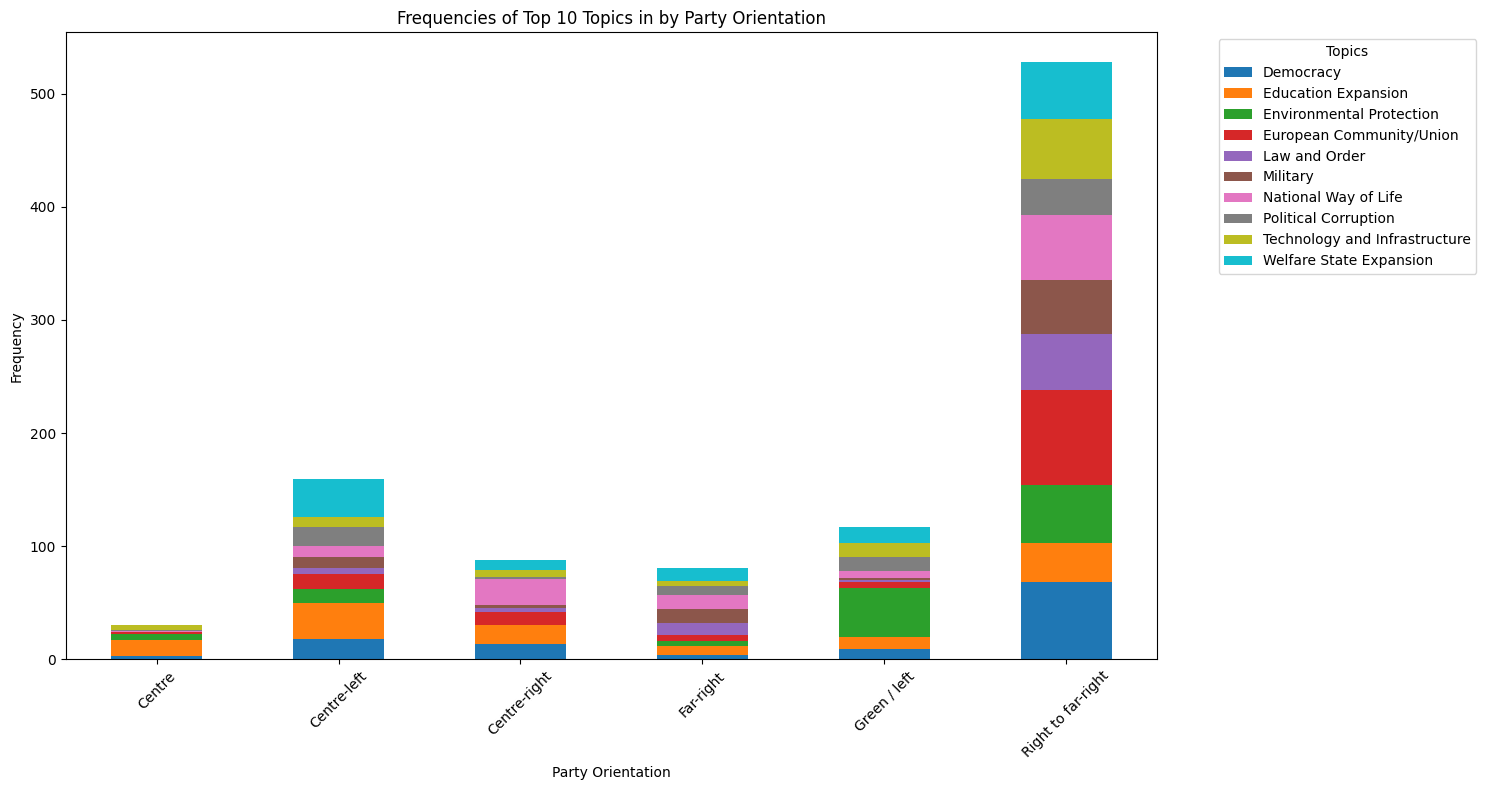

In [143]:
new_df = new_df[(new_df['Party_orientation'].notna()) & (new_df['Party_orientation'] != '-')  & (new_df['topic_primary_alt'] != 'Political Authority')]

# Create a frequency table of topics by Party_orientation
frequency_table = new_df.groupby(['Party_orientation', 'topic_primary_alt']).size().unstack(fill_value=0)

# Plot bar charts for frequencies by Party_orientation
frequency_table.plot(kind='bar', figsize=(15, 8), stacked=True)
plt.xlabel('Party Orientation')
plt.ylabel('Frequency')
plt.title('Frequencies of Top 10 Topics in by Party Orientation')
plt.xticks(rotation=45)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

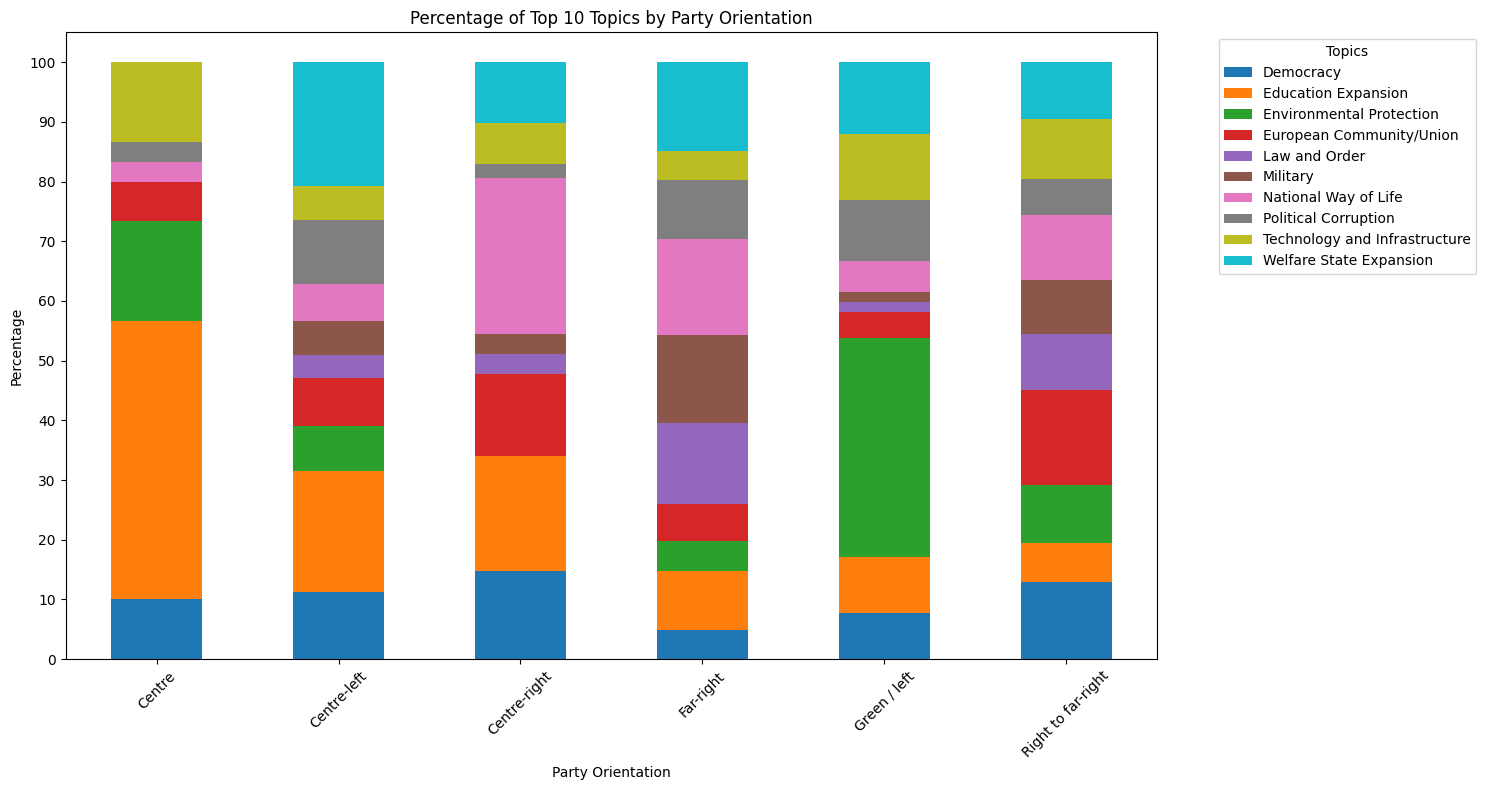

In [144]:
import matplotlib.pyplot as plt

# Filter the DataFrame
new_df = new_df[(new_df['Party_orientation'].notna()) & (new_df['Party_orientation'] != '-') & (new_df['topic_primary_alt'] != 'Political Authority')]

# Create a frequency table of topics by Party_orientation
frequency_table = new_df.groupby(['Party_orientation', 'topic_primary_alt']).size().unstack(fill_value=0)

# Normalize the frequency table to get percentages
percentage_table = frequency_table.div(frequency_table.sum(axis=1), axis=0) * 100

# Plot bar charts for percentages by Party_orientation
percentage_table.plot(kind='bar', figsize=(15, 8), stacked=True)
plt.xlabel('Party Orientation')
plt.ylabel('Percentage')
plt.title('Percentage of Top 10 Topics by Party Orientation')
plt.xticks(rotation=45)
plt.yticks(range(0, 101, 10))
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


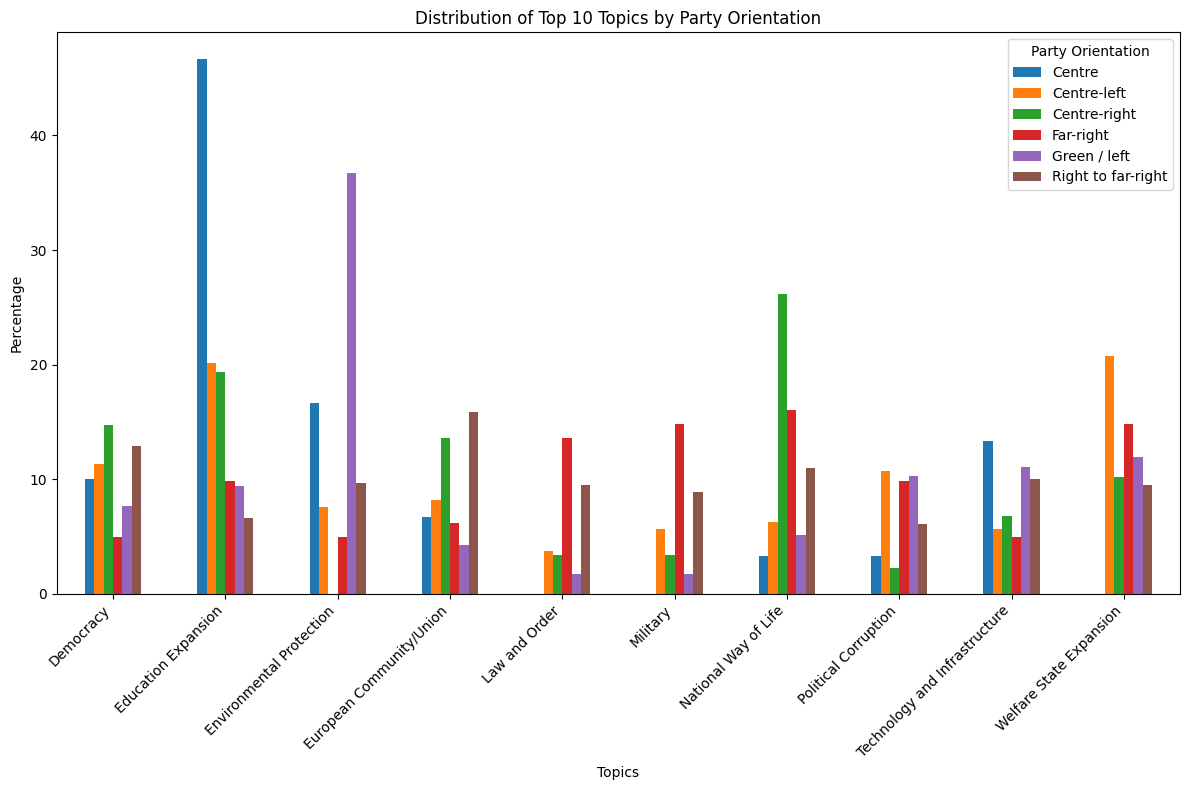

In [145]:
new_df = new_df[(new_df['Party_orientation'].notna()) & (new_df['Party_orientation'] != '-') & (new_df['topic_primary_alt'] != 'Political Authority')]


# Task 1: Create a frequency table
freq_table = new_df.groupby('Party_orientation')['topic_primary_alt'].value_counts(normalize=True).unstack().fillna(0)
freq_table = freq_table * 100  # Convert to percentage
#print(freq_table)
# Task 2: Create a grouped bar chart
freq_table.T.plot(kind='bar', figsize=(12, 8))

plt.title('Distribution of Top 10 Topics by Party Orientation')
plt.xlabel('Topics')
plt.ylabel('Percentage')
plt.legend(title='Party Orientation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()